In [48]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import kstest
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats import kruskal
import scikit_posthocs as sp

In [2]:
df = pd.read_csv('dataset.csv')
df.head()


,User ID,Age,Gender,Country,Purchase Amount,Purchase Date,Product Category
0,1,56.0,Female,USA,331.79,2021-11-21,Sports
1,2,69.0,Male,Australia,335.72,2022-03-05,Home & Kitchen
2,3,46.0,NaN,Germany,493.18,NaN,Books
3,4,32.0,Male,Germany,80.97,2023-06-08,Sports
4,5,60.0,Female,UK,21.75,NaN,Beauty


In [3]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   User ID           15000 non-null  int64  
 1   Age               13500 non-null  float64
 2   Gender            14250 non-null  object 
 3   Country           13800 non-null  object 
 4   Purchase Amount   13200 non-null  float64
 5   Purchase Date     13950 non-null  object 
 6   Product Category  14100 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 820.4+ KB
None
            User ID           Age  Purchase Amount
count  15000.000000  13500.000000     13200.000000
mean    7500.500000     43.396000       253.217720
std     4330.271354     14.927082       143.113919
min        1.000000     18.000000         5.050000
25%     3750.750000     31.000000       130.335000
50%     7500.500000     43.000000       253.645000
75%    11250.250000     56.000000       378

In [4]:
df.isnull().sum()

User ID                0
Age                 1500
Gender               750
Country             1200
Purchase Amount     1800
Purchase Date       1050
Product Category     900
dtype: int64

In [5]:
# Data Cleaning

df['Age'] = df['Age'].fillna(df['Age'].mean())
df['Gender'] = df['Gender'].replace(np.nan, 'Unknown')
df['Country'] = df['Country'].replace(np.nan, 'Unknown')
df['Product Category'] = df['Product Category'].replace(np.nan, 'Other')

## Drop rows where 'Purchase Amount' has NaN values
df = df.dropna(subset=['Purchase Amount'])

### Fixing date variable
df['Purchase Date'] = df['Purchase Date'].replace('Unknown', pd.NaT)
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'], errors='coerce')



In [6]:
# Adding Age Group column 
bins = [18, 30, 40, 50, 60, 70]
labels = ['18-29', '30-39', '40-49', '50-59', '60-69']
df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

In [7]:
df.head()

,User ID,Age,Gender,Country,Purchase Amount,Purchase Date,Product Category,Age Group
0,1,56.0,Female,USA,331.79,2021-11-21,Sports,50-59
1,2,69.0,Male,Australia,335.72,2022-03-05,Home & Kitchen,60-69
2,3,46.0,Unknown,Germany,493.18,NaT,Books,40-49
3,4,32.0,Male,Germany,80.97,2023-06-08,Sports,30-39
4,5,60.0,Female,UK,21.75,NaT,Beauty,60-69


In [8]:
# 1. Total and average purchase amount by product category
product_summary = df.groupby('Product Category')['Purchase Amount'].agg(['count', 'sum', 'mean']).sort_values(by='sum', ascending=False)

# 2. Analyzing purchases by country
country_summary = df.groupby('Country')['Purchase Amount'].agg(['count', 'sum', 'mean']).sort_values(by='sum', ascending=False)

# 3. Analyzing purchases by gender and country
gender_country_summary = df.groupby(['Gender', 'Country'])['Purchase Amount'].agg(['count', 'sum', 'mean']).sort_values(by='sum', ascending=False)


print(product_summary)
print(country_summary)
print(gender_country_summary)



                  count        sum        mean
Product Category                              
Clothing           2124  544115.08  256.174708
Sports             2094  530725.06  253.450363
Electronics        2069  526740.41  254.586955
Books              2059  519377.39  252.247397
Home & Kitchen     2049  516547.16  252.097199
Beauty             2009  502552.49  250.150567
Other               796  202416.31  254.291847
           count        sum        mean
Country                                
France      2165  544181.49  251.354037
Germany     2041  522782.82  256.140529
Canada      2029  510898.26  251.798058
Australia   1998  504352.90  252.428879
UK          1973  499843.59  253.341911
USA         1952  498070.87  255.159257
Unknown     1042  262343.97  251.769645
                   count        sum        mean
Gender  Country                                
Female  France       721  179186.70  248.525243
Male    France       696  178746.04  256.819023
Female  Canada       685 

In [9]:
# 4. Analyzing purchases by age
age_summary = df.groupby('Age Group', observed=True)['Purchase Amount'].agg(['count', 'sum', 'mean']).sort_values(by='sum', ascending=False)

print(age_summary)


           count        sum        mean
Age Group                              
40-49       3644  918503.74  252.059204
18-29       2710  681501.03  251.476395
30-39       2355  618133.74  262.477172
50-59       2244  564862.78  251.721381
60-69       2247  559472.61  248.986475


In [10]:
df['Purchase Date'].info()

<class 'pandas.core.series.Series'>
Index: 13200 entries, 0 to 14999
Series name: Purchase Date
Non-Null Count  Dtype         
--------------  -----         
12267 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 206.2 KB


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13200 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   User ID           13200 non-null  int64         
 1   Age               13200 non-null  float64       
 2   Gender            13200 non-null  object        
 3   Country           13200 non-null  object        
 4   Purchase Amount   13200 non-null  float64       
 5   Purchase Date     12267 non-null  datetime64[ns]
 6   Product Category  13200 non-null  object        
 7   Age Group         13200 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 838.1+ KB


In [12]:
# Seasonal Trends
df['Purchase Month'] = df['Purchase Date'].dt.month
monthly_summary = df.groupby('Purchase Month')['Purchase Amount'].agg(['count', 'sum', 'mean'])
print(monthly_summary)



                count        sum        mean
Purchase Month                              
1.0              1086  274984.98  253.209006
2.0               950  239196.45  251.785737
3.0              1021  257527.17  252.230333
4.0               984  243362.48  247.319593
5.0               989  244931.90  247.656117
6.0               996  245028.28  246.012329
7.0              1010  259364.58  256.796614
8.0              1113  282502.96  253.821168
9.0              1004  263009.74  261.961892
10.0             1087  275879.33  253.798832
11.0              957  242123.01  253.002100
12.0             1070  270563.34  252.862935


In [13]:
# Seasonal trends by product category
seasonal_product_summary = df.groupby(['Purchase Month', 'Product Category'])['Purchase Amount'].agg(['count', 'sum', 'mean']).reset_index()
print(seasonal_product_summary)

#  Trends by country and month
seasonal_country_summary = df.groupby(['Purchase Month', 'Country'])['Purchase Amount'].agg(['count', 'sum', 'mean']).reset_index()
print(seasonal_country_summary)

#  Top countries for Electronics
electronics_data = df[df['Product Category'] == 'Electronics']
electronics_country_summary = electronics_data.groupby('Country', observed=True)['Purchase Amount'].agg(['count', 'sum', 'mean']).sort_values(by='sum', ascending=False)
print(electronics_country_summary)

#  Electronics trends by age group
electronics_age_summary = df[df['Product Category'] == 'Electronics'].groupby('Age Group', observed=True)['Purchase Amount'].agg(['count', 'sum', 'mean']).sort_values(by='sum', ascending=False)
print(electronics_age_summary)

#  Electronics trends by gender
electronics_gender_summary = df[df['Product Category'] == 'Electronics'].groupby('Gender', observed=True)['Purchase Amount'].agg(['count', 'sum', 'mean']).sort_values(by='sum', ascending=False)
print(electronics_gender_summary)

#  Compare top products by age group
product_age_summary = df.groupby(['Age Group', 'Product Category'], observed=True)['Purchase Amount'].agg(['count', 'sum', 'mean']).sort_values(by='sum', ascending=False).reset_index()
top_products_by_age = product_age_summary.groupby('Age Group', observed=True).head(3)
print(top_products_by_age)

    Purchase Month Product Category  count       sum        mean
0              1.0           Beauty    163  39763.93  243.950491
1              1.0            Books    174  46259.06  265.856667
2              1.0         Clothing    176  40880.10  232.273295
3              1.0      Electronics    172  43147.04  250.854884
4              1.0   Home & Kitchen    172  44919.45  261.159593
..             ...              ...    ...       ...         ...
79            12.0         Clothing    155  41048.55  264.829355
80            12.0      Electronics    160  39342.13  245.888312
81            12.0   Home & Kitchen    189  48721.96  257.788148
82            12.0            Other     66  16583.70  251.268182
83            12.0           Sports    164  39450.91  240.554329

[84 rows x 5 columns]
    Purchase Month    Country  count       sum        mean
0              1.0  Australia    165  42586.45  258.099697
1              1.0     Canada    166  40724.22  245.326627
2              1.0  


           count       sum        mean
Country                               
Germany      367  95234.92  259.495695
UK           332  85897.39  258.727078
France       313  79677.01  254.559137
USA          304  77482.31  254.876020
Canada       316  75274.61  238.210791
Australia    285  73298.81  257.188807
Unknown      152  39875.36  262.337895
           count        sum        mean
Age Group                              
40-49        581  148982.57  256.424389
18-29        407  100743.31  247.526560
30-39        369   97648.71  264.630650
60-69        364   91291.33  250.800357
50-59        348   88074.49  253.087615
         count        sum        mean
Gender                               
Female     690  183566.09  266.037812
Other      654  162840.97  248.992309
Male       629  156603.10  248.971542
Unknown     96   23730.25  247.190104
   Age Group Product Category  count        sum        mean
0      40-49           Sports    594  150631.54  253.588451
1      40-49      El

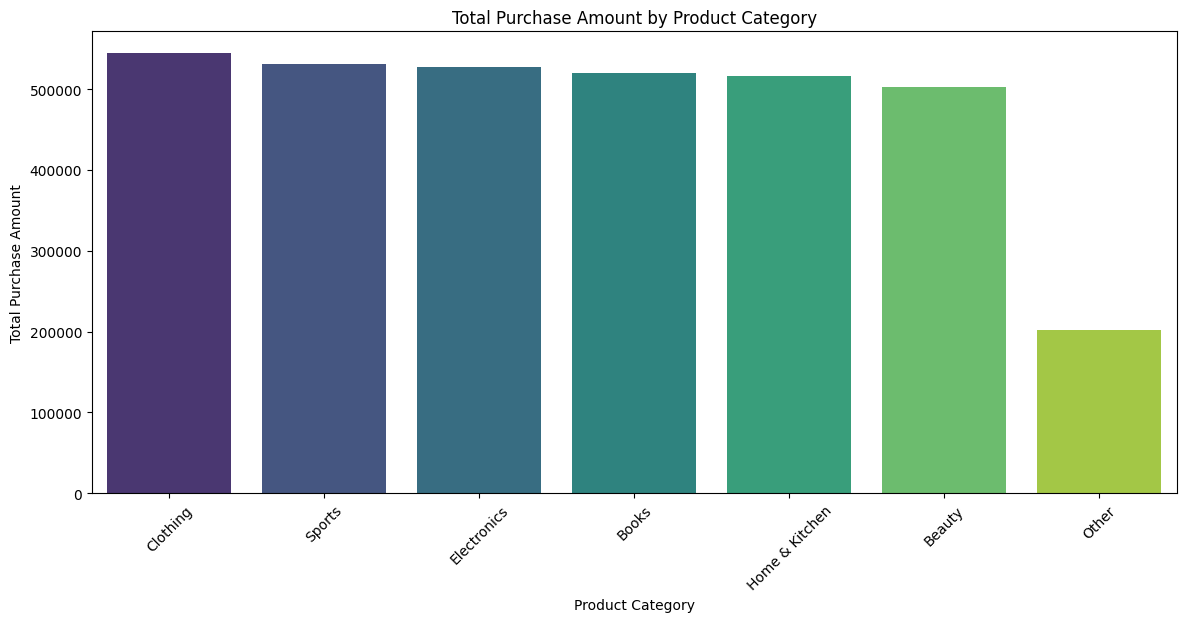

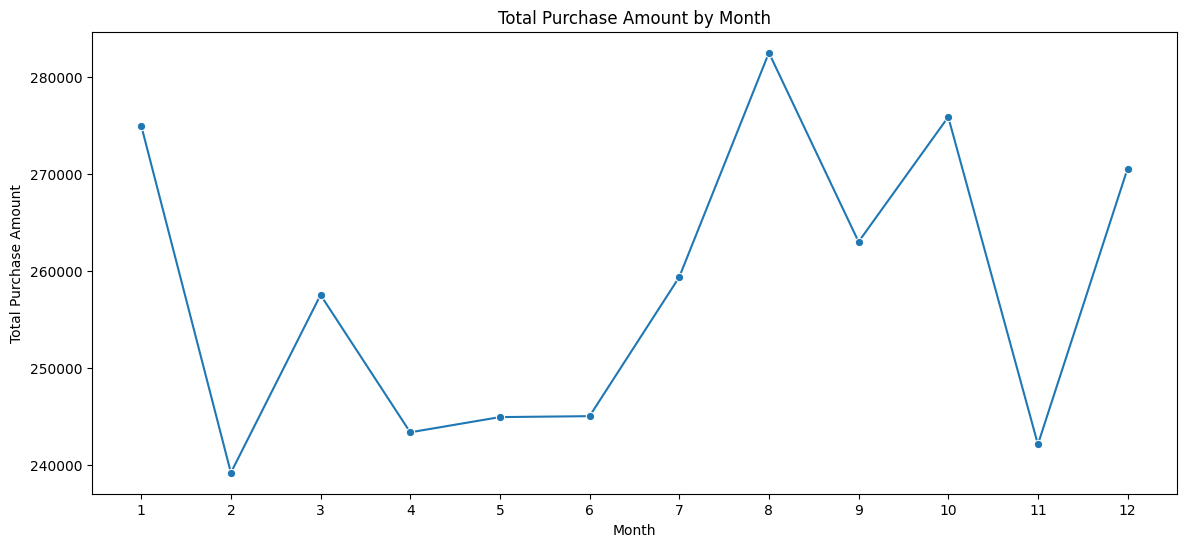

In [14]:
# Visualization examples #

# Barplot Total Purchase Amount by Product Category
plt.figure(figsize=(14, 6))
sns.barplot(x=product_summary.index, y=product_summary['sum'], hue=product_summary.index, palette='viridis', dodge=False)
plt.title('Total Purchase Amount by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Purchase Amount')
plt.xticks(rotation=45)
plt.show()
# Lineplot Total Purchase Amount by Month
plt.figure(figsize=(14, 6))
sns.lineplot(x=monthly_summary.index, y=monthly_summary['sum'], marker='o')
plt.title('Total Purchase Amount by Month')
plt.xlabel('Month')
plt.ylabel('Total Purchase Amount')
plt.xticks(range(1, 13))
plt.show()

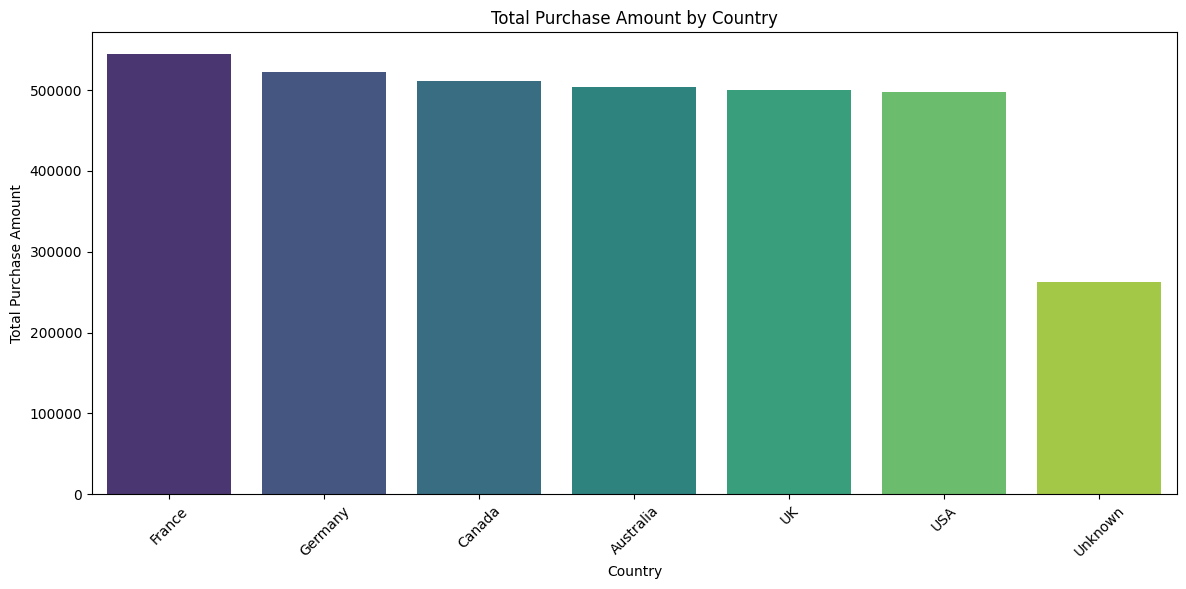

In [15]:
# Barplot Total Purchase Amount by Country
plt.figure(figsize=(14, 6))
sns.barplot(x=country_summary.index, y=country_summary['sum'], hue=country_summary.index, palette='viridis', dodge=False)
plt.title('Total Purchase Amount by Country')
plt.xlabel('Country')
plt.ylabel('Total Purchase Amount')
plt.xticks(rotation=45)
plt.show()


In [16]:
df.head()

,User ID,Age,Gender,Country,Purchase Amount,Purchase Date,Product Category,Age Group,Purchase Month
0,1,56.0,Female,USA,331.79,2021-11-21,Sports,50-59,11.0
1,2,69.0,Male,Australia,335.72,2022-03-05,Home & Kitchen,60-69,3.0
2,3,46.0,Unknown,Germany,493.18,NaT,Books,40-49,NaN
3,4,32.0,Male,Germany,80.97,2023-06-08,Sports,30-39,6.0
4,5,60.0,Female,UK,21.75,NaT,Beauty,60-69,NaN


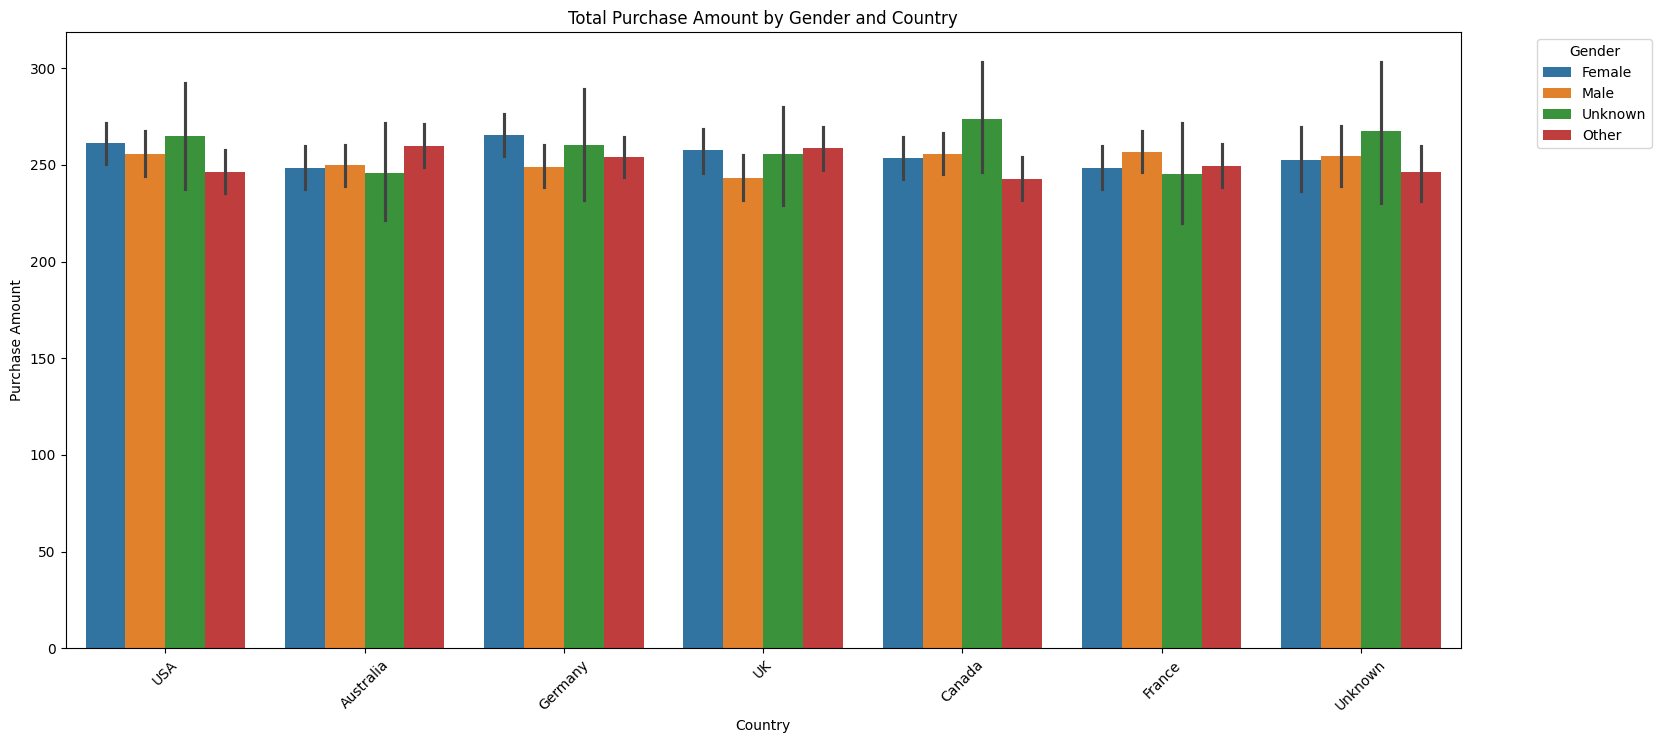

In [17]:
# Barplot Total Purchase Amount by Gender and Country
plt.figure(figsize=(18, 8))
sns.barplot(x='Country', y='Purchase Amount', hue='Gender', data=df)
plt.title('Total Purchase Amount by Gender and Country')
plt.xlabel('Country')
plt.ylabel('Purchase Amount')
plt.xticks(rotation=45)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [18]:
df.head()

,User ID,Age,Gender,Country,Purchase Amount,Purchase Date,Product Category,Age Group,Purchase Month
0,1,56.0,Female,USA,331.79,2021-11-21,Sports,50-59,11.0
1,2,69.0,Male,Australia,335.72,2022-03-05,Home & Kitchen,60-69,3.0
2,3,46.0,Unknown,Germany,493.18,NaT,Books,40-49,NaN
3,4,32.0,Male,Germany,80.97,2023-06-08,Sports,30-39,6.0
4,5,60.0,Female,UK,21.75,NaT,Beauty,60-69,NaN


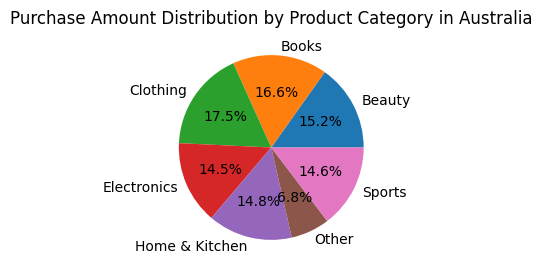

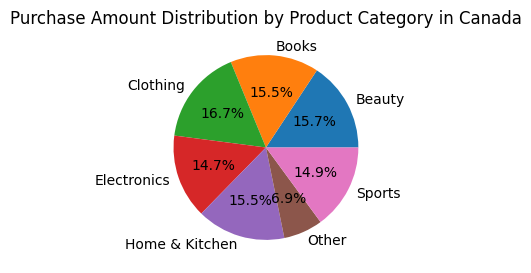

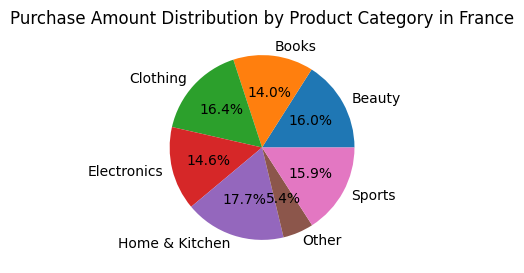

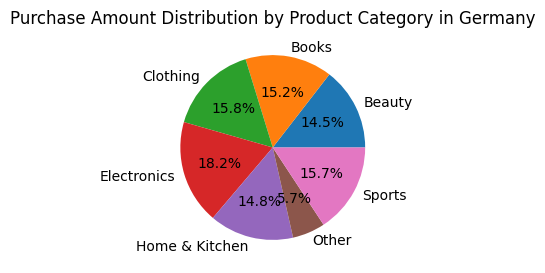

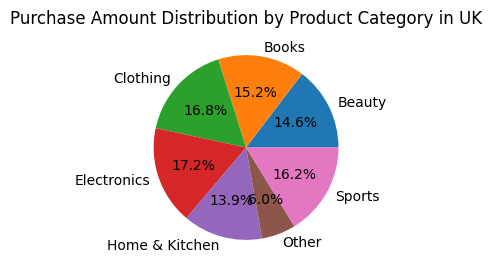

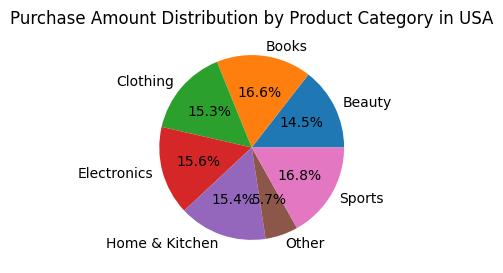

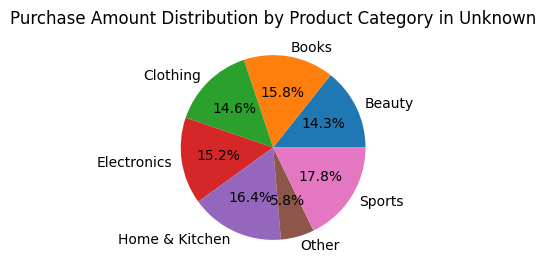

In [19]:
# Piechart Distribution of Purchase Amount by Country and Product Category
# Grouping data by both country and product category
category_purchase = df.groupby(['Country', 'Product Category'])['Purchase Amount'].sum().reset_index()

# Plotting a pie chart for each country
for country in category_purchase['Country'].unique():
    plt.figure(figsize=(5, 3))
    subset = category_purchase[category_purchase['Country'] == country]
    plt.pie(subset['Purchase Amount'], labels=subset['Product Category'], autopct='%1.1f%%')
    plt.title(f'Purchase Amount Distribution by Product Category in {country}')
    plt.show()


In [20]:
# Further Analysis with Linear Regression and ANOVA to see which variables influence each other. Question is: Weather gender, age , 
# country and product category influence the purchase amount?

In [21]:
df.head()

,User ID,Age,Gender,Country,Purchase Amount,Purchase Date,Product Category,Age Group,Purchase Month
0,1,56.0,Female,USA,331.79,2021-11-21,Sports,50-59,11.0
1,2,69.0,Male,Australia,335.72,2022-03-05,Home & Kitchen,60-69,3.0
2,3,46.0,Unknown,Germany,493.18,NaT,Books,40-49,NaN
3,4,32.0,Male,Germany,80.97,2023-06-08,Sports,30-39,6.0
4,5,60.0,Female,UK,21.75,NaT,Beauty,60-69,NaN


In [22]:
# Correlation Analysis (numerical variables)
correlation_matrix = df[['Age', 'Purchase Amount']].corr()
print("Correlation Matrix:\n", correlation_matrix)

correlation_value = correlation_matrix.loc['Age', 'Purchase Amount']

print("\nInterpretation:")
if abs(correlation_value) < 0.1:
    print("The correlation between 'Age' and 'Purchase Amount' is {:.2f}, indicating no correlation.".format(correlation_value))
elif 0.1 <= abs(correlation_value) < 0.3:
    print("The correlation between 'Age' and 'Purchase Amount' is {:.2f}, indicating a weak correlation.".format(correlation_value))
elif 0.3 <= abs(correlation_value) < 0.5:
    print("The correlation between 'Age' and 'Purchase Amount' is {:.2f}, indicating a moderate correlation.".format(correlation_value))
else:
    print("The correlation between 'Age' and 'Purchase Amount' is {:.2f}, indicating a strong correlation.".format(correlation_value))

print("This suggests that as age changes, the purchase amount may change according to the strength of the correlation indicated.")

Correlation Matrix:
                      Age  Purchase Amount
Age              1.00000         -0.01345
Purchase Amount -0.01345          1.00000

Interpretation:
The correlation between 'Age' and 'Purchase Amount' is -0.01, indicating no correlation.
This suggests that as age changes, the purchase amount may change according to the strength of the correlation indicated.


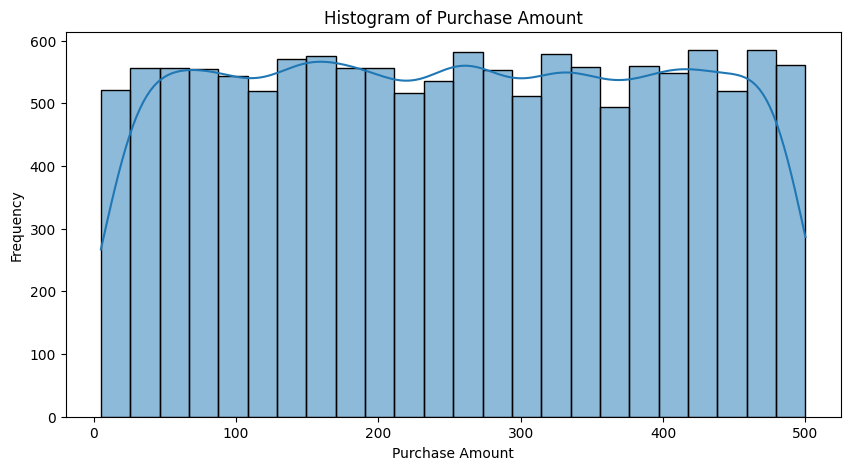

Kolmogorov-Smirnov Test:
 KstestResult(statistic=np.float64(0.05997232450660994), pvalue=np.float64(1.032856689495597e-41), statistic_location=np.float64(377.45), statistic_sign=np.int8(-1))
The p-value is less than 0.05, suggesting we reject the null hypothesis that the data follows a normal distribution.
This implies that the distribution of the 'Purchase Amount' data significantly deviates from a normal distribution.


In [23]:
# Histogram for visual inspection of normality
plt.figure(figsize=(10, 5))
sns.histplot(df['Purchase Amount'], kde=True)
plt.title('Histogram of Purchase Amount')
plt.xlabel('Purchase Amount')
plt.ylabel('Frequency')
plt.show()

# Kolmogorov-Smirnov Test
ks_test = kstest(df['Purchase Amount'].dropna(), 'norm', args=(df['Purchase Amount'].mean(), df['Purchase Amount'].std()))
print("Kolmogorov-Smirnov Test:\n", ks_test)

# Interpret K-S test results
if ks_test.pvalue < 0.05:
    print("The p-value is less than 0.05, suggesting we reject the null hypothesis that the data follows a normal distribution.")
    print("This implies that the distribution of the 'Purchase Amount' data significantly deviates from a normal distribution.")
else:
    print("The p-value is greater than 0.05, indicating we fail to reject the null hypothesis.")
    print("This suggests that there is not enough evidence to say the 'Purchase Amount' data deviates from a normal distribution, and it may be approximately normal.")


In [26]:
#### BoxCox transformation of Purchase Amount
df['Purchase Amount(boxcox)'], lambda_ = stats.boxcox(df['Purchase Amount'])

In [29]:
###Log10 transformation
df['Purchase Amount_log10'] = np.log10(df['Purchase Amount'])

In [39]:
###Log transformation
df['Purchase Amount_log'] = np.log(df['Purchase Amount'])

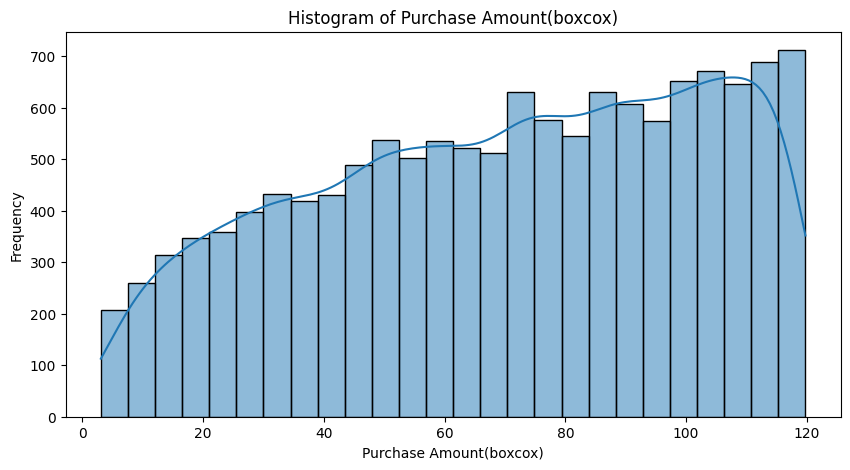

Kolmogorov-Smirnov Test:
 KstestResult(statistic=np.float64(0.06555288507551738), pvalue=np.float64(9.266461273027293e-50), statistic_location=np.float64(86.16870315166571), statistic_sign=np.int8(-1))
The p-value is less than 0.05, suggesting we reject the null hypothesis that the data follows a normal distribution.
This implies that the distribution of the 'Purchase Amount' data significantly deviates from a normal distribution.


In [28]:
### Checking normality after boxcox
# Histogram for visual inspection of normality
plt.figure(figsize=(10, 5))
sns.histplot(df['Purchase Amount(boxcox)'], kde=True)
plt.title('Histogram of Purchase Amount(boxcox)')
plt.xlabel('Purchase Amount(boxcox)')
plt.ylabel('Frequency')
plt.show()

# Kolmogorov-Smirnov Test
ks_test = kstest(df['Purchase Amount(boxcox)'].dropna(), 'norm', args=(df['Purchase Amount(boxcox)'].mean(), df['Purchase Amount(boxcox)'].std()))
print("Kolmogorov-Smirnov Test:\n", ks_test)

# Interpret K-S test results
if ks_test.pvalue < 0.05:
    print("The p-value is less than 0.05, suggesting we reject the null hypothesis that the data follows a normal distribution.")
    print("This implies that the distribution of the 'Purchase Amount' data significantly deviates from a normal distribution.")
else:
    print("The p-value is greater than 0.05, indicating we fail to reject the null hypothesis.")
    print("This suggests that there is not enough evidence to say the 'Purchase Amount' data deviates from a normal distribution, and it may be approximately normal.")


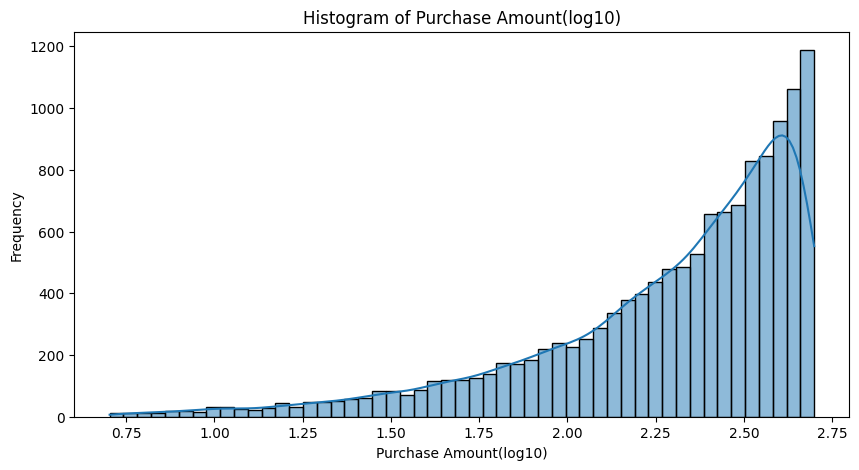

Kolmogorov-Smirnov Test:
 KstestResult(statistic=np.float64(0.1402201479178835), pvalue=np.float64(6.917560909485944e-227), statistic_location=np.float64(2.6989265727162115), statistic_sign=np.int8(1))
The p-value is less than 0.05, suggesting we reject the null hypothesis that the data follows a normal distribution.
This implies that the distribution of the 'Purchase Amount' data significantly deviates from a normal distribution.


In [ ]:
#### Checking normailty after log10
### Checking normality after boxcox
# Histogram for visual inspection of normality
plt.figure(figsize=(10, 5))
sns.histplot(df['Purchase Amount_log10'], kde=True)
plt.title('Histogram of Purchase Amount(log10)')
plt.xlabel('Purchase Amount(log10)')
plt.ylabel('Frequency')
plt.show()

# Kolmogorov-Smirnov Test
ks_test = kstest(df['Purchase Amount_log10'].dropna(), 'norm', args=(df['Purchase Amount_log10'].mean(), df['Purchase Amount_log10'].std()))
print("Kolmogorov-Smirnov Test:\n", ks_test)

# Interpret K-S test results
if ks_test.pvalue < 0.05:
    print("The p-value is less than 0.05, suggesting we reject the null hypothesis that the data follows a normal distribution.")
    print("This implies that the distribution of the 'Purchase Amount' data significantly deviates from a normal distribution.")
else:
    print("The p-value is greater than 0.05, indicating we fail to reject the null hypothesis.")
    print("This suggests that there is not enough evidence to say the 'Purchase Amount' data deviates from a normal distribution, and it may be approximately normal.")


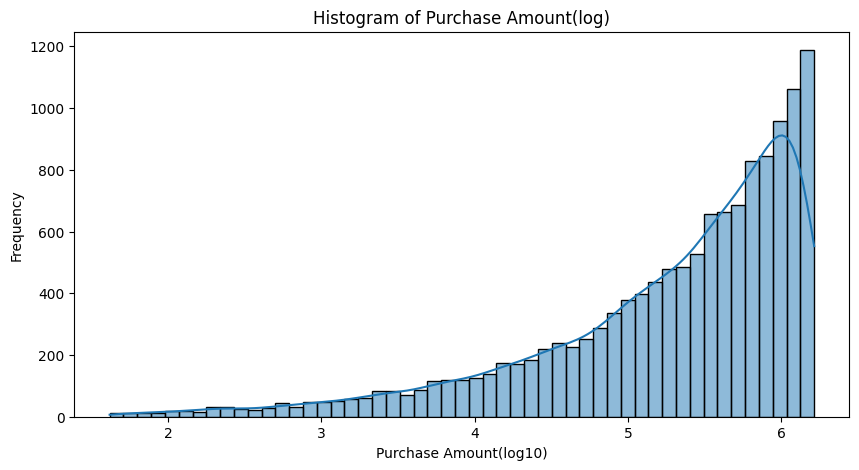

Kolmogorov-Smirnov Test:
 KstestResult(statistic=np.float64(0.1402201479178835), pvalue=np.float64(6.917560909485944e-227), statistic_location=np.float64(6.214508093421858), statistic_sign=np.int8(1))
The p-value is less than 0.05, suggesting we reject the null hypothesis that the data follows a normal distribution.
This implies that the distribution of the 'Purchase Amount' data significantly deviates from a normal distribution.


In [40]:
#### Checking normailty after log
### Checking normality after boxcox
# Histogram for visual inspection of normality
plt.figure(figsize=(10, 5))
sns.histplot(df['Purchase Amount_log'], kde=True)
plt.title('Histogram of Purchase Amount(log)')
plt.xlabel('Purchase Amount(log10)')
plt.ylabel('Frequency')
plt.show()

# Kolmogorov-Smirnov Test
ks_test = kstest(df['Purchase Amount_log'].dropna(), 'norm', args=(df['Purchase Amount_log'].mean(), df['Purchase Amount_log'].std()))
print("Kolmogorov-Smirnov Test:\n", ks_test)

# Interpret K-S test results
if ks_test.pvalue < 0.05:
    print("The p-value is less than 0.05, suggesting we reject the null hypothesis that the data follows a normal distribution.")
    print("This implies that the distribution of the 'Purchase Amount' data significantly deviates from a normal distribution.")
else:
    print("The p-value is greater than 0.05, indicating we fail to reject the null hypothesis.")
    print("This suggests that there is not enough evidence to say the 'Purchase Amount' data deviates from a normal distribution, and it may be approximately normal.")


In [53]:

# Prepare the data for regression (encoding categorical variables)
data_encoded = pd.get_dummies(df, columns=['Gender', 'Country', 'Product Category'], drop_first=True)
X = data_encoded[['Age'] + [col for col in data_encoded.columns if 'Gender_' in col or 'Country_' in col or 'Product Category_' in col]]
y = data_encoded['Purchase Amount']

# Fit the linear regression model
reg_model = LinearRegression()
reg_model.fit(X, y)

# Make predictions
y_pred = reg_model.predict(X)

# Calculate residuals
residuals = y - y_pred

# Check normality of residuals using Shapiro-Wilk test
stat, p_value = stats.shapiro(residuals)
print(f'Shapiro-Wilk Test Statistic: {stat:.4f}, p-value: {p_value:.4f}')

# Interpret the p-value
alpha = 0.05
if p_value > alpha:
    print('Residuals appear to be normally distributed (fail to reject H0)')
else:
    print('Residuals do not appear to be normally distributed (reject H0)')

# Display regression results
print("Linear Regression Coefficients:")
for feature, coef in zip(X.columns, reg_model.coef_):
    print(f"{feature}: {coef:.4f}")
print(f"Intercept: {reg_model.intercept_:.4f}")



Shapiro-Wilk Test Statistic: 0.9551, p-value: 0.0000
Residuals do not appear to be normally distributed (reject H0)
Linear Regression Coefficients:
Age: -0.1322
Gender_Male: -3.3970
Gender_Other: -4.0425
Gender_Unknown: 2.1754
Country_Canada: -0.5921
Country_France: -1.0895
Country_Germany: 3.7268
Country_UK: 0.9151
Country_USA: 2.6450
Country_Unknown: -0.5377
Product Category_Books: 1.9850
Product Category_Clothing: 5.9155
Product Category_Electronics: 4.2132
Product Category_Home & Kitchen: 1.8001
Product Category_Other: 3.9543
Product Category_Sports: 3.1158
Intercept: 257.4479


c:\Users\User\Desktop\User Purchase Behavior Analysis Dataset\purchase behavior analysis\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 13200.
  res = hypotest_fun_out(*samples, **kwds)


In [58]:
def t_test_group_difference(df, group_col, group1, group2, target_col):
    """
    Perform a T-test to compare target variable values between two groups.

    Parameters:
    df (pd.DataFrame): The DataFrame containing data.
    group_col (str): The column name for the grouping variable.
    group1 (str): The first group to compare.
    group2 (str): The second group to compare.
    target_col (str): The column name for the target variable.

    Returns:
    None: Prints the T-test results.
    """
    # Extract target variable values for the specified groups
    group1_values = df[df[group_col] == group1][target_col]
    group2_values = df[df[group_col] == group2][target_col]
    
    # Perform T-test
    t_test_result = stats.ttest_ind(group1_values, group2_values, nan_policy='omit')
    
    # Display T-test results
    print(f"\nT-test between {group1} and {group2} for '{target_col}':")
    print(f"T-statistic: {t_test_result.statistic:.4f}, p-value: {t_test_result.pvalue:.4f}")
    if t_test_result.pvalue < 0.05:
        print("The result is statistically significant (p < 0.05). There is a significant difference between the groups.")
    else:
        print("The result is not statistically significant (p >= 0.05). No significant difference between the groups.")

# Example usage:
# t_test_group_difference(df, 'Country', 'USA', 'Australia', 'Purchase Amount')

In [67]:
t_test_group_difference(df, 'Gender', 'Female', 'Male', 'Purchase Amount')


T-test between Female and Male for 'Purchase Amount':
T-statistic: 1.0993, p-value: 0.2717
The result is not statistically significant (p >= 0.05). No significant difference between the groups.


In [63]:
def multiple_t_tests(df, group_col, target_col, group_pairs):
    """
    Perform T-tests to compare target variable values between multiple group pairs.

    Parameters:
    df (pd.DataFrame): The DataFrame containing data.
    group_col (str): The column name for the grouping variable.
    target_col (str): The column name for the target variable.
    group_pairs (list of tuples): A list of tuples, each containing two groups to compare.

    Returns:
    None: Prints the T-test results for each group pair.
    """
    for group1, group2 in group_pairs:
        # Extract target variable values for the specified groups
        group1_values = df[df[group_col] == group1][target_col]
        group2_values = df[df[group_col] == group2][target_col]
        
        # Perform T-test
        t_test_result = stats.ttest_ind(group1_values, group2_values, nan_policy='omit')
        
        # Display T-test results
        print(f"\nT-test between {group1} and {group2} for '{target_col}':")
        print(f"T-statistic: {t_test_result.statistic:.4f}, p-value: {t_test_result.pvalue:.4f}")
        if t_test_result.pvalue < 0.05:
            print("The result is statistically significant (p < 0.05). There is a significant difference between the groups.")
        else:
            print("The result is not statistically significant (p >= 0.05). No significant difference between the groups.")



In [64]:
df['Country'].unique()

array(['USA', 'Australia', 'Germany', 'UK', 'Canada', 'France', 'Unknown'],
      dtype=object)

In [65]:
# Example usage:
# Define the group pairs you want to compare
group_pairs = [('USA', 'Australia'), ('USA', 'Canada'), ('Australia', 'Canada'), ('USA', 'Germany'), ('USA', 'France'), ('Germany', 'France')]

# Call the function
multiple_t_tests(df, 'Country', 'Purchase Amount', group_pairs)


T-test between USA and Australia for 'Purchase Amount':
T-statistic: 0.6002, p-value: 0.5484
The result is not statistically significant (p >= 0.05). No significant difference between the groups.

T-test between USA and Canada for 'Purchase Amount':
T-statistic: 0.7351, p-value: 0.4623
The result is not statistically significant (p >= 0.05). No significant difference between the groups.

T-test between Australia and Canada for 'Purchase Amount':
T-statistic: 0.1411, p-value: 0.8878
The result is not statistically significant (p >= 0.05). No significant difference between the groups.

T-test between USA and Germany for 'Purchase Amount':
T-statistic: -0.2146, p-value: 0.8301
The result is not statistically significant (p >= 0.05). No significant difference between the groups.

T-test between USA and France for 'Purchase Amount':
T-statistic: 0.8428, p-value: 0.3994
The result is not statistically significant (p >= 0.05). No significant difference between the groups.

T-test between Ger

In [ ]:
###Kruskal-Wallis and Dunn's

# Suppress specific FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def multiple_kruskal_wallis_with_posthoc(data, dependent_var, independent_vars, alpha=0.05):
    """
    Perform multiple Kruskal-Wallis tests and post-hoc Dunn's test for a given DataFrame.
    
    Parameters:
    data (DataFrame): The input DataFrame.
    dependent_var (str): The name of the dependent variable (continuous).
    independent_vars (list): A list of independent variables (categorical).
    alpha (float): Significance level for Kruskal-Wallis test (default is 0.05).
    
    Returns:
    dict: A dictionary containing test results and post-hoc results where applicable.
    """
    results = {}

    for var in independent_vars:
        # Group data by the current independent variable
        groups = [group[dependent_var].values for name, group in data.groupby(var, observed=True)]
        
        # Perform the Kruskal-Wallis test
        stat, p_value = kruskal(*groups)
        
        # Append Kruskal-Wallis results
        results[var] = {
            'Kruskal-Wallis Statistic': stat,
            'p-value': p_value,
            'Post-hoc Test': None  # Placeholder for post-hoc test results
        }
        
        # Perform post-hoc Dunn's test if the Kruskal-Wallis test is significant
        if p_value < alpha:
            dunn_result = sp.posthoc_dunn(data, val_col=dependent_var, group_col=var, p_adjust='bonferroni')
            results[var]['Post-hoc Test'] = dunn_result
    
    # Return results
    return results



In [51]:
# Example usage
independent_vars = ['Gender', 'Age Group', 'Purchase Month', 'Country', 'Product Category']
test_results = multiple_kruskal_wallis_with_posthoc(df, 'Purchase Amount', independent_vars)

In [52]:
# Display results
for var, result in test_results.items():
    print(f"\nKruskal-Wallis Test for {var}:")
    print(f"  Statistic: {result['Kruskal-Wallis Statistic']:.4f}, p-value: {result['p-value']:.4e}")
    if result['p-value'] < 0.05:
        print("  Significant! Performing Dunn's post-hoc test:")
        print(result['Post-hoc Test'])

# Reset warnings to default behavior if needed
warnings.simplefilter(action='default', category=FutureWarning)


Kruskal-Wallis Test for Gender:
  Statistic: 2.6123, p-value: 4.5534e-01

Kruskal-Wallis Test for Age Group:
  Statistic: 12.7457, p-value: 1.2587e-02
  Significant! Performing Dunn's post-hoc test:
          18-29     30-39     40-49    50-59     60-69
18-29  1.000000  0.062618  1.000000  1.00000  1.000000
30-39  0.062618  1.000000  0.058362  0.10746  0.013687
40-49  1.000000  0.058362  1.000000  1.00000  1.000000
50-59  1.000000  0.107460  1.000000  1.00000  1.000000
60-69  1.000000  0.013687  1.000000  1.00000  1.000000

Kruskal-Wallis Test for Purchase Month:
  Statistic: 9.9912, p-value: 5.3118e-01

Kruskal-Wallis Test for Country:
  Statistic: 1.9177, p-value: 9.2711e-01

Kruskal-Wallis Test for Product Category:
  Statistic: 2.3011, p-value: 8.9003e-01


In [ ]:
# The current analysis implies that basic demographic variables and product categories do not have a strong 
# direct relationship with purchase amounts. 
#The significant p-value of 0.013687 between the 30-39 and 60-69 age groups indicates a notable difference in the ranks of these two groups.
#All other comparisons did not yield significant differences, suggesting that the differences in ranks among those age groups are not statistically significant.